# 🧠 IU X-ray Report Generator (Updated Version)

This notebook now:
- Uses only **frontal chest X-rays** (via `indiana_projections.csv`)
- Joins with **`indiana_reports.csv`** using the `image` column
- Uses **DenseNet-121** to classify labels
- Uses **Flan-T5 (with LoRA)** to generate:
  - Initial report from image findings
  - Refined report using `indication` and optionally `comparison`
- Evaluates reports using **ROUGE** and **BLEU**


# IU X-Ray Complete Pipeline Notebook

This notebook includes:
- Multi-label classification training of DenseNet-121 with data augmentation and weighted loss
- Report generation fine-tuning of Flan-T5-small with LoRA
- Inference & reporting producing a CSV of results with BLEU & ROUGE metrics

In [17]:
!pip install --quiet torch torchvision transformers torchxrayvision scikit-learn rouge-score nltk datasets pydicom peft accelerate fuzzywuzzy python-Levenshtein matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [34]:
import os, re
import torch
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
import torchvision.transforms as T
import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

nltk.download('punkt')

CONFIG = {
    'data_dir': '/kaggle/input/chest-xrays-indiana-university',
    'merged_file': '/kaggle/input/merged',
    'image_dir': '/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    'chexpert_labels_file': '/kaggle/input/labels-and-model/chexpert_labels.txt',
    'batch_size_cls': 8,
    'epochs_cls': 3,
    'lr_cls': 1e-4,
    'image_size': 224,
    't5_model': 'google/flan-t5-small',
    'lora_r': 8,
    'lora_alpha': 16,
    'output_csv': '/kaggle/working/iu_xray_full_results.csv',
    'lora_save_dir': '/kaggle/working/t5_lora_model'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Load preprocessed data
df = pd.read_csv(f"{CONFIG['merged_file']}/merged_preprocessed.csv")

# Stratified split
df['first_label'] = df['chexpert_labels'].apply(lambda x: x.split(';')[0] if isinstance(x, str) and x else 'None')
# Filter out classes with only one sample in 'first_label'
value_counts = df['first_label'].value_counts()
df = df[df['first_label'].isin(value_counts[value_counts > 1].index)]
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['first_label'])
print('Train/Val sizes:', len(df_train), len(df_val))

Train/Val sizes: 1160 291


In [20]:
# Load CheXpert labels
with open(CONFIG['chexpert_labels_file']) as f:
    CHEXPERT_LABELS = [line.strip() for line in f if line.strip()]

# Manual mapping for non-matches
MANUAL_MAP = {
    'pulmonary fibrosis': 'Fibrosis',
    'interstitial fibrosis': 'Fibrosis'
}

def map_mesh_to_chexpert(mesh_terms):
    terms = [t.strip().lower() for t in mesh_terms.split(';') if t.strip()]
    mapped = set()
    for t in terms:
        for lbl in CHEXPERT_LABELS:
            if lbl.lower() in t or fuzz.partial_ratio(lbl.lower(), t) > 80:
                mapped.add(lbl)
        for k,v in MANUAL_MAP.items():
            if k in t:
                mapped.add(v)
    return list(mapped)

In [21]:
# Data augmentation transforms
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    T.ToTensor(),
    # The following line is changed:
    lambda x: x.repeat(3, 1, 1), # Repeat grayscale channel 3 times
    T.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229]),
    # lambda x: x.unsqueeze(0) # Removed unsqueeze as the model expects (C, H, W)
])
val_transform = T.Compose([
    T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    T.ToTensor(),
    # The following line is changed:
    lambda x: x.repeat(3, 1, 1), # Repeat grayscale channel 3 times
    T.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229]),
    # lambda x: x.unsqueeze(0) # Removed unsqueeze as the model expects (C, H, W)
])

In [22]:
# Dataset class
class XRayDataset(Dataset):
    def __init__(self, df, split_size, mode='cls'):
        self.df = df.reset_index(drop=True)
        self.split_size = split_size
        self.mode = mode
        if mode=='txt':
            self.tokenizer = AutoTokenizer.from_pretrained(CONFIG['t5_model'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      # Load normalized PNG image
      img_path = os.path.join(CONFIG['image_dir'], row.filename)
      img = Image.open(img_path).convert('L')  # Convert to grayscale

      if self.mode=='cls':
        transform = train_transform if idx < self.split_size else val_transform
        img = transform(img)
        labels = row['chexpert_labels']  # Use pre-mapped labels
        y = torch.tensor([1 if lbl in labels else 0 for lbl in CHEXPERT_LABELS], dtype=torch.float32)
        return img, y
      else:
        img = val_transform(img)
        with torch.no_grad():
            logits = cls_model(img.unsqueeze(0).to(device))
        probs = torch.sigmoid(logits)[0].cpu().numpy()
        findings = [lbl for i,lbl in enumerate(CHEXPERT_LABELS) if probs[i]>0.5]
        prompt = f"History: {row.indication_clean}. Findings: {', '.join(findings)}"
        enc = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        tgt = self.tokenizer(row.impression_clean, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        return {
            'input_ids': enc.input_ids.squeeze(),
            'attention_mask': enc.attention_mask.squeeze(),
            'labels': tgt.input_ids.squeeze()
        }

In [23]:
# Prepare loaders with weighted sampling
train_ds = XRayDataset(df_train, len(df_train), mode='cls')
val_ds   = XRayDataset(df_val, len(df_train), mode='cls')

# Compute pos weights
ys = torch.stack([y for _,y in train_ds])
pos_counts = ys.sum(dim=0)
total = ys.size(0)
pos_weight = (total - pos_counts)/(pos_counts+1e-8)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# Sampler
weights = ys.sum(dim=1).numpy()
sampler = WeightedRandomSampler(weights, num_samples=total, replacement=True)

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size_cls'], sampler=sampler)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG['batch_size_cls'])

In [27]:
cls_model = xrv.models.DenseNet(weights='densenet121-res224-chex').to(device)
# Access classifier's in_features directly from cls_model.features
cls_model.classifier = torch.nn.Linear(cls_model.features.norm5.num_features, len(CHEXPERT_LABELS)).to(device)  # Replace 'model.classifier' with 'features.norm5'
# The following line is changed:
cls_model.features.conv0 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device) # Modify the first convolutional layer to accept 3 channels
# The following line is added to fix the error
cls_model.op_threshs = None # Reset op_threshs to avoid dimension mismatch

optimizer = torch.optim.AdamW(cls_model.parameters(), lr=CONFIG['lr_cls'])


for epoch in range(CONFIG['epochs_cls']):
    cls_model.train()
    total_loss = 0
    for imgs,labels in train_loader:
        imgs,labels = imgs.to(device), labels.to(device)
        preds = cls_model(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{CONFIG['epochs_cls']} Loss: {total_loss/len(train_loader):.4f}")

# Validation
cls_model.eval()
y_t, y_p = [], []
with torch.no_grad():
    for imgs,labels in val_loader:
        out = torch.sigmoid(cls_model(imgs.to(device))).cpu().numpy()
        y_p.extend((out>0.5).astype(int)); y_t.extend(labels.numpy())

print(classification_report(y_t, y_p, target_names=CHEXPERT_LABELS, zero_division=0))

Epoch 1/3 Loss: 1.3770
Epoch 2/3 Loss: 1.2475
Epoch 3/3 Loss: 1.2530
                            precision    recall  f1-score   support

               Atelectasis       0.19      1.00      0.32        56
              Cardiomegaly       0.25      0.98      0.40        62
             Consolidation       0.01      1.00      0.02         3
                     Edema       0.02      1.00      0.05         7
                  Effusion       0.08      1.00      0.14        22
Enlarged Cardiomediastinum       0.00      0.00      0.00         0
                  Fracture       0.10      0.96      0.19        28
               Lung Lesion       0.27      0.68      0.39        53
              Lung Opacity       0.36      1.00      0.53       105
                No Finding       0.00      0.00      0.00        17
          Pleural Effusion       0.08      1.00      0.14        22
             Pleural Other       0.00      0.00      0.00         0
                 Pneumonia       0.02      0.8

In [28]:
# Save trained classification model
torch.save(cls_model.state_dict(), '/kaggle/working/densenet_finetuned.pt')
print("Saved DenseNet model")

Saved DenseNet model


Fine-tune Flan-T5-small with LoRA (NEWLY ADDED)

In [35]:
from torch.utils.data import DataLoader
from torch.optim import AdamW

# Setup
lf_model.train()
optimizer = AdamW(lf_model.parameters(), lr=5e-5)
batch_size = 4
epochs = 1

# Tokenized dataset should already be available
train_loader = DataLoader(txt_ds, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = lf_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

# Save LoRA model
lf_model.save_pretrained(CONFIG['lora_save_dir'])
print(f"✅ LoRA model saved at {CONFIG['lora_save_dir']}")

Epoch 1/1 - Loss: 6.6283
✅ LoRA model saved at /kaggle/working/t5_lora_model


In [36]:
# Inference & Reporting
from peft import PeftModel
import gc

# Load text model
base_t5 = AutoModelForSeq2SeqLM.from_pretrained(CONFIG['t5_model'])
# Update the path to the LoRA model if necessary
lf_model = PeftModel.from_pretrained(
    base_t5,
    model_id="/kaggle/input/labels-and-model",
    is_local=True
).to(device)
tokenizer = AutoTokenizer.from_pretrained(CONFIG['t5_model'])

rouge = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
bleu_fn = SmoothingFunction().method1

df = df.head(100)

batch_size = 20
partial_results = []

for idx, row in enumerate(df.iterrows()):
    _, row = row
    img_path = os.path.join(CONFIG['image_dir'], row.filename)
    img = Image.open(img_path).convert('L')
    img = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = cls_model(img)
    probs = torch.sigmoid(logits)[0].cpu().numpy()
    preds = [lbl for i, lbl in enumerate(CHEXPERT_LABELS) if probs[i] > 0.5]

    prompt0 = f"Findings: {', '.join(preds)}. Generate a radiology report."
    inputs0 = tokenizer(prompt0, return_tensors='pt', truncation=True).to(device)
    rpt0 = lf_model.generate(**inputs0, max_length=256)
    text0 = tokenizer.decode(rpt0[0], skip_special_tokens=True)

    prompt1 = f"History: {row.indication_clean}. Findings: {', '.join(preds)}. Generate a refined radiology report."
    inputs1 = tokenizer(prompt1, return_tensors='pt', truncation=True).to(device)
    rpt1 = lf_model.generate(**inputs1, max_length=256)
    text1 = tokenizer.decode(rpt1[0], skip_special_tokens=True)

    r1 = rouge.score(row.impression_clean, text0)['rouge1'].fmeasure
    b1 = sentence_bleu([row.impression_clean.split()], text0.split(), smoothing_function=bleu_fn)
    r2 = rouge.score(row.impression_clean, text1)['rouge1'].fmeasure
    b2 = sentence_bleu([row.impression_clean.split()], text1.split(), smoothing_function=bleu_fn)

    partial_results.append({
        'uid': row.uid,
        'predicted_labels': ';'.join(preds),
        'report_initial': text0,
        'report_refined': text1,
        'rouge1_init': r1,
        'rouge1_ref': r2,
        'bleu_init': b1,
        'bleu_ref': b2
    })

    # Flush memory + partial saves
    if (idx + 1) % batch_size == 0:
        pd.DataFrame(partial_results).to_csv(CONFIG['output_csv'], mode='a', header=not os.path.exists(CONFIG['output_csv']), index=False)
        partial_results = []
        torch.cuda.empty_cache()
        gc.collect()
        print(f"✅ Saved batch up to sample {idx+1}")

# Save any remaining rows
if partial_results:
    pd.DataFrame(partial_results).to_csv(CONFIG['output_csv'], mode='a', header=not os.path.exists(CONFIG['output_csv']), index=False)
    print("✅ Saved final batch.")

print(f"✅ All results saved to {CONFIG['output_csv']}")

✅ Saved batch up to sample 20
✅ Saved batch up to sample 40
✅ Saved batch up to sample 60
✅ Saved batch up to sample 80
✅ Saved batch up to sample 100
✅ All results saved to /kaggle/working/iu_xray_full_results.csv


**Visualisation of Results and Metrics:**

BLEU & ROUGE Score Distributions

→ Compare initial vs refined reports.

Predicted Label Co-occurrence Heatmap

→ See which diseases are often predicted together.

BLEU/ROUGE Improvement Histograms

→ Measure how much patient history improves report quality.

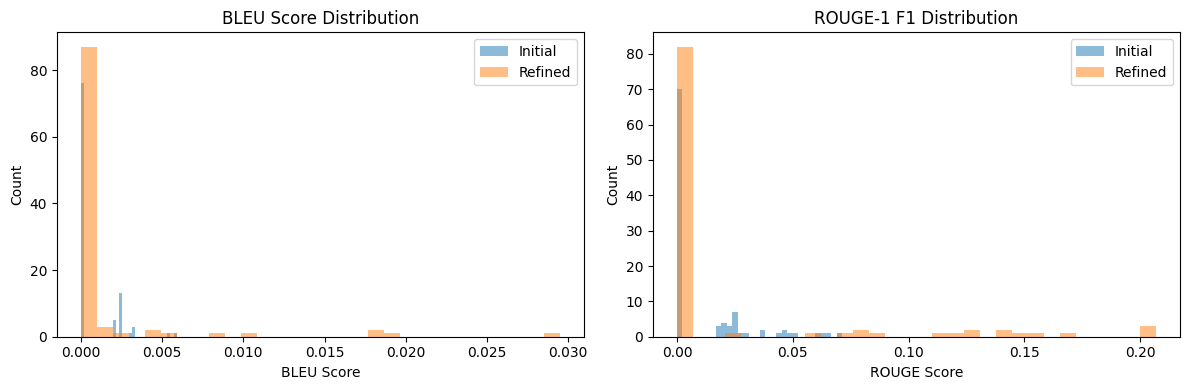

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

# Load results
CONFIG = {
    'output_csv': '/kaggle/working/iu_xray_full_results.csv'
}
df_results = pd.read_csv(CONFIG['output_csv'])

# === BLEU and ROUGE Score Distributions ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_results['bleu_init'], bins=30, alpha=0.5, label='Initial')
plt.hist(df_results['bleu_ref'], bins=30, alpha=0.5, label='Refined')
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score"); plt.ylabel("Count"); plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_results['rouge1_init'], bins=30, alpha=0.5, label='Initial')
plt.hist(df_results['rouge1_ref'], bins=30, alpha=0.5, label='Refined')
plt.title("ROUGE-1 F1 Distribution")
plt.xlabel("ROUGE Score"); plt.ylabel("Count"); plt.legend()

plt.tight_layout()
plt.show()

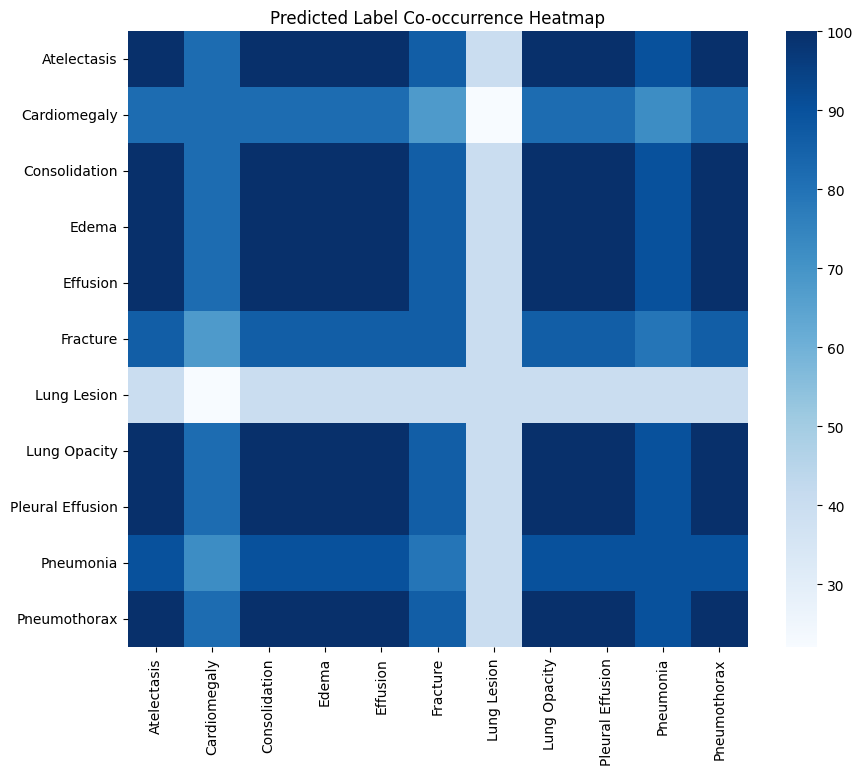

In [39]:
df_results['label_list'] = df_results['predicted_labels'].fillna('').apply(lambda x: x.split(';') if x else [])
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(df_results['label_list'])
co_matrix = pd.DataFrame(binary_matrix.T @ binary_matrix, index=mlb.classes_, columns=mlb.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=False, cmap='Blues')
plt.title("Predicted Label Co-occurrence Heatmap")
plt.show()

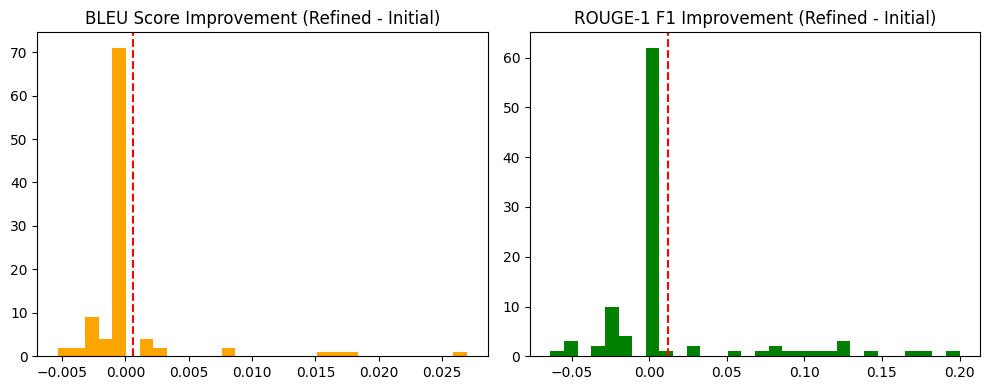

In [40]:
df_results['bleu_improvement'] = df_results['bleu_ref'] - df_results['bleu_init']
df_results['rouge_improvement'] = df_results['rouge1_ref'] - df_results['rouge1_init']

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(df_results['bleu_improvement'], bins=30, color='orange')
plt.axvline(df_results['bleu_improvement'].mean(), color='red', linestyle='--')
plt.title("BLEU Score Improvement (Refined - Initial)")

plt.subplot(1, 2, 2)
plt.hist(df_results['rouge_improvement'], bins=30, color='green')
plt.axvline(df_results['rouge_improvement'].mean(), color='red', linestyle='--')
plt.title("ROUGE-1 F1 Improvement (Refined - Initial)")

plt.tight_layout()
plt.show()

In the next visual we get exact label co-occurrence values.

This makes it easier to identify strongly associated diagnoses (e.g., "Effusion" and "Edema") and it improves the model's debugging and clinical interpretation.

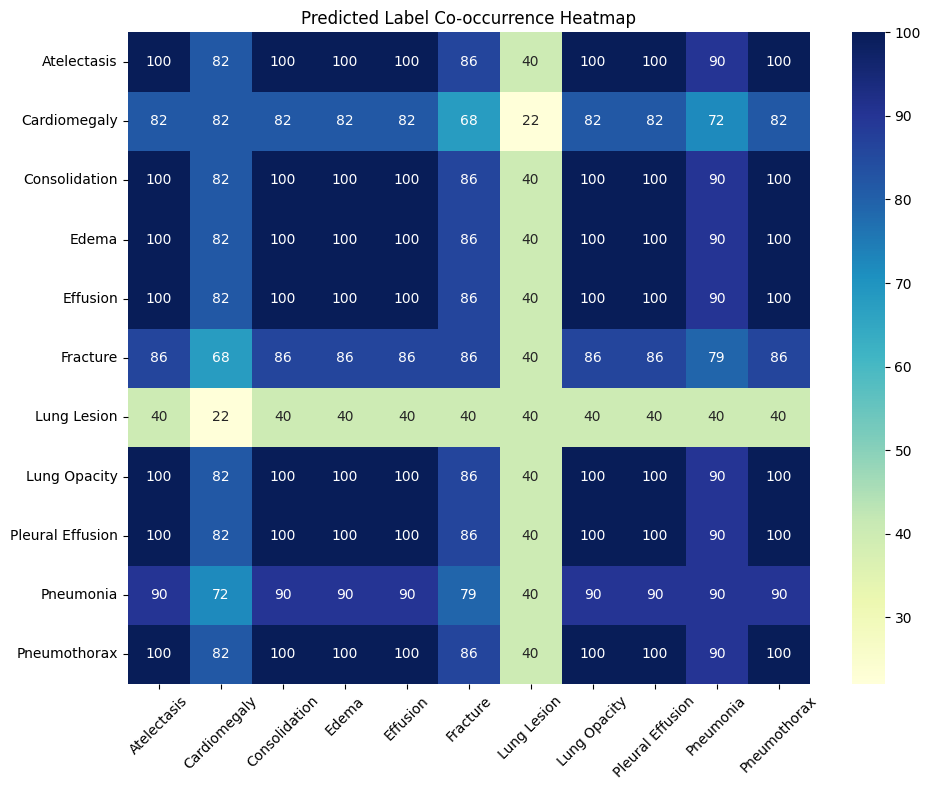

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_results['label_list'] = df_results['predicted_labels'].fillna('').apply(lambda x: x.split(';') if x else [])
binary_matrix = mlb.fit_transform(df_results['label_list'])
co_matrix = pd.DataFrame(binary_matrix.T @ binary_matrix, index=mlb.classes_, columns=mlb.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Predicted Label Co-occurrence Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()